In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

In [2]:
# Set the paths for the dataset
data_dir = os.path.join(os.getcwd(), "archive", "chest_xray")
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "val")

# Define the dimensions of the input images
input_shape = (1, 256, 256)  # Grayscale images

# Define latent dimensions
latent_dim = 256

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Create data transforms
data_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((input_shape[1], input_shape[2])),
    transforms.ToTensor()
])

# Load the dataset
train_dataset = ImageFolder(train_dir, transform=data_transforms)
test_dataset = ImageFolder(test_dir, transform=data_transforms)
val_dataset = ImageFolder(val_dir, transform=data_transforms)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Define the encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Define the fully connected layers
        self.fc_mu = nn.Linear(64 * 32 * 32, latent_dim)
        self.fc_logvar = nn.Linear(64 * 32 * 32, latent_dim)
        
        # Define the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 32 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (256, 16, 16)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_shape[0], kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        z = self.decoder(z)
        return z

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [5]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Define the encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Define the decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_shape[0], kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Initialize the model
model = VAE().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Set random seed for reproducibility
torch.manual_seed(42)

# Training loop
num_epochs = 15
kld_rate = 0.0001
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        # Forward pass
        out = model(data)
        # out, mu, logvar = model(data)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        # kl_divergence = kld_rate * 0.5 * torch.sum(-1 - logvar + mu.pow(2) + logvar.exp())
        kl_divergence = 0
        loss = F.binary_cross_entropy(out, data, size_average=False) + kl_divergence

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 99:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, batch_idx + 1, len(train_loader), running_loss / 100))
            running_loss = 0.0

Epoch [1/15], Step [100/163], Loss: 1241895.4575
Epoch [2/15], Step [100/163], Loss: 1192102.1087
Epoch [3/15], Step [100/163], Loss: 1187238.7188
Epoch [4/15], Step [100/163], Loss: 1187925.8625
Epoch [5/15], Step [100/163], Loss: 1185345.8800
Epoch [6/15], Step [100/163], Loss: 1184263.8587
Epoch [7/15], Step [100/163], Loss: 1185305.1538
Epoch [8/15], Step [100/163], Loss: 1183378.8325
Epoch [9/15], Step [100/163], Loss: 1182899.2588
Epoch [10/15], Step [100/163], Loss: 1183693.3513


KeyboardInterrupt: 

In [9]:
# Generate images using the trained VAE model
with torch.no_grad():
    model.eval()
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        recon_batch = model(data)
        if i == 0:
            save_image(data, os.path.join(data_dir, "original_images.png"))
            save_image(recon_batch, os.path.join(data_dir, "reconstructed_images.png"))
        break

In [13]:
torch.save(model.state_dict(), os.path.join(os.getcwd(), "model2.pth"))

In [17]:
from ignite.metrics import FID, InceptionScore
from ignite.engine import Engine, Events

model.load_state_dict(torch.load(os.path.join(os.getcwd(), "model2.pth")))

fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.convert('RGB')
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        model.eval()
        real = batch[0].to(device)
        fake = model(real)
        return fake.repeat(1,3,1,1), real.repeat(1,3,1,1)

In [18]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")
fid_values = []
is_values = []
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")
evaluator.run(test_loader)
metrics = evaluator.state.metrics
fid_score = metrics['fid']
is_score = metrics['is']
fid_values.append(fid_score)
is_values.append(is_score)
print(f"*   FID : {fid_score:4f}")
print(f"*    IS : {is_score:4f}")

*   FID : 0.133022
*    IS : 3.014291


In [ ]:
real_batch = next(iter(train_loader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training aImages")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

Text(0, 0.5, 'Loss')

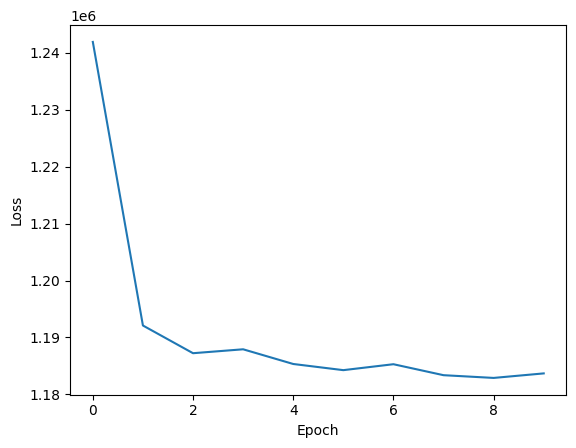

In [10]:
plt.plot([1241895.4575,
1192102.1087,
1187238.7188,
1187925.8625,
1185345.8800,
1184263.8587,
1185305.1538,
1183378.8325,
1182899.2588,
1183693.3513])
plt.xlabel('Epoch')
plt.ylabel('Loss')